This project involves building a sentiment analysis system using reviews from the Yelp dataset. The project leverages TensorFlow/Keras for model training and evaluation, and involves working with text preprocessing, neural network design, and data handling. The development included such stages:


**Data Preprocessing**

Reviews were filtered and categorized into positive, negative, and neutral sentiments based on their star ratings and keyword presence. Only reviews with matching star rating and keywords categories were included in the final dataset to avoid inconsistencies and to ensure the reliability of the sentiment labels. Finally, texts were tokenized and padded to prepare them for model training.

**Model Creation**

A Recurrent Neural Network with LSTM layers was designed to classify the sentiment of reviews. The model was trained using a training set, with validation and early stopping mechanisms to optimize performance.

**Evaluation and Prediction**

After training, the model's performance was evaluated on a validation set, and predictions were displayed alongside the original review texts to verify the model's accuracy.

**Results Showcase**

Metrics such as loss and accuracy were plotted, and the model was saved for future use. Predictions were then examined for a sample of test data to demonstrate the model's effectiveness. The achived prediction accuracy is 88%.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import random
import os
import pickle
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

def categorize_review(sentences):
    positive_keywords = ["good", "excellent", "satisfied", "great", "outstanding", "wonderful", "terrific", "amazing", "fantastic", "wow",
                        "superb", "impressive", "delightful", "value for money", "tasty", "friendly", "exceptional", "perfect", "love",
                        "clean", "fresh", "delicious", "enjoyable", "pleasant", "satisfying", "appealing", "inviting", "flavorful", "tender",
                        "crisp", "authentic", "well-prepared", "rich", "scrumptious", "mouthwatering", "liked", "enjoyed", "underrated"]

    negative_keywords = ["bad", "poor", "disappointed", "awful", "overpriced", "horrible", "terrible", "atrocious", "abysmal", "never go back",
                        "dreadful", "lousy", "disastrous", "pathetic", "miserable", "disliked", "awful, slow", "rude", "dirty",
                        "bland", "unpleasant", "disappointing", "unappetizing", "soggy", "stale", "greasy", "undercooked",
                        "unfriendly", "boring", "mediocre", "underwhelming", "generic", "dry", "overcooked", "tasteless"]

    neutral_keywords = ["average", "standard", "typical", "okay", "fine", "decent", "moderate", "fair", "so-so", "middle-of-the-road",
                        "ordinary", "acceptable", "neutral", "indifferent", "passable", "adequate", "common", "usual", "normal"]


    positive_count, negative_count, neutral_count, unknown_count = 0, 0, 0, 0 # Initialize counters for each category
    categories = set()  # Create a set to store the categories

    for sentence in sentences:
        words = sentence.lower().split() # Split the sentence into words and convert them to lowercase
        # Check if any keywords are in the sentence and update the categoriesif any(word in words for word in positive_keywords):
            categories.add('positive')
        if any(word in words for word in negative_keywords):
            categories.add('negative')
        if any(word in words for word in neutral_keywords):
            categories.add('neutral')

    # Determine the final category
    if len(categories) > 1:
        return 'multiple_categories'
    elif 'positive' in categories:
        return 'positive'
    elif 'negative' in categories:
        return 'negative'
    elif 'neutral' in categories:
        return 'neutral'
    else:
        return 'not_present'

def load_and_preprocess_dataset(input_data_dir, output_data_dir, max_sequences_per_class, validation_percentage, test_percentage):
    file_path = f'{input_data_dir}/yelp_review.json'
    filtered_sequences = []  # List for reviews where the sentiment matches the rating
    sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}

    with open(file_path, 'r') as file:
        for line in file:
            if all(value >= max_sequences_per_class for value in sentiment_counts.values()):
                break # Stop when we have enough reviews in each category

            review = json.loads(line)
            text = review.get('text', '')
            star_rating = review.get('stars', 0)

            # If the rating is 4 or 5, the review is positive; if 3, it's neutral; if 1 or 2, it's negative
            if len(text) < 500:
                if star_rating in [4, 5]:
                    star_label = 'positive'
                elif star_rating in [1, 2]:
                    star_label = 'negative'
                elif star_rating == 3:
                    star_label = 'neutral'
                else:
                    star_label = 'not_present'

                sentiment_label = categorize_review([text])

                # Get reviews where sentiment labels match the star ratings
                if sentiment_label == star_label and sentiment_label != 'multiple_categories' and sentiment_label != 'not_present':
                    if sentiment_counts[sentiment_label] < max_sequences_per_class:
                        filtered_sequences.append({
                            'text': text,
                            'sentiment_label': sentiment_label,
                            'star_label': star_label
                        })
                        sentiment_counts[sentiment_label] += 1

    random.shuffle(filtered_sequences)

    texts = [sequence['text'] for sequence in filtered_sequences]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts) # Train the tokenizer on the text data from the list of texts
    sequences = tokenizer.texts_to_sequences(texts) # Convert text to a sequence of numerical indices (tokens) using the trained tokenizer
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post') # Pad sequences to the maximum length

    x_data = padded_sequences
    y_data = [sequence['sentiment_label'] for sequence in filtered_sequences]

    label_map = {'positive': 0, 'negative': 1, 'neutral': 2} # Assign numerical representation to labels
    y_data = [label_map[label] for label in y_data]

    # Split the data into training, validation, and test sets

    x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=test_percentage / 100, stratify=y_data, random_state=42)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train_val, y_train_val, test_size=validation_percentage / (test_percentage + validation_percentage), stratify=y_train_val, random_state=42)

    # Save data
    np.savez_compressed(os.path.join(output_data_dir, 'yelp_review_data_preprocessed.npz'),
                        x_train=x_train, y_train=y_train,
                        x_validation=x_validation, y_validation=y_validation,
                        x_test=x_test, y_test=y_test,
                        classes=label_map)

    print(f"Total sequences: {len(padded_sequences)}")
    for i in range(1):
        print(f"Sequence length: {len(padded_sequences[i])}\n")

    # Save tokenizer
    with open(os.path.join(output_data_dir, 'tokenizer.pickle'), 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Display 5 random reviews
    num_random_sequences = 5
    random_sample_indices = random.sample(range(len(filtered_sequences)), num_random_sequences)
    for i, index in enumerate(random_sample_indices, start=1):
        print(f"Random Sequence {i}:")
        print(f"Sentiment label: {filtered_sequences[index]['sentiment_label']}")
        print(f"Star label: {filtered_sequences[index]['star_label']}")
        print(f"Text: {filtered_sequences[index]['text']}\n")
        print(f"Tokenized Text: {padded_sequences[index]}\n")
        print("--------------------")

    # Display words with their corresponding tokens

    word_index = tokenizer.word_index
    print("First 100 Word Index Mapping:")
    count = 0
    for word, index in word_index.items():
        print(f"{word}: {index}")
        count += 1
        if count >= 200:
            break

input_data_dir = '/content/drive/MyDrive/sentiment_analysis/yelp_dataset'
output_data_dir = '/content/drive/MyDrive/sentiment_analysis/'

load_and_preprocess_dataset(input_data_dir, output_data_dir, max_sequences_per_class=4000, validation_percentage=25, test_percentage=5)


Total sequences: 12000
Sequence length: 104

Random Sequence 1:
Sentiment label: positive
Star label: positive
Text: Solid improvement since last visit.  

Service- much improved.  Kid named Dillon gave a great service.  

Ambiance is very casual.  Order and sit, they bring food to you. 

Food- tasty and lots of options.  Not fancy.  Very affordable.  

Family of four for about 30$.  That's a great deal w today's prices. 

If you are looking for a fast, casual Asian option, give this place a try.

Tokenized Text: [  611  2127   254   232   270    22   102  2171  1469  2015 15338   317
     3    30    22   585     7    29   944    76     2   502    15   508
    12     5    24    12   296     2   453     9   259    16   723    29
  1088   327     9   728     8    63   312   300     3    30   564   914
  3762   139    38    24    27   261     8     3   246   944  1102   590
   158    14    20     3   115     0     0     0     0     0     0     0
     0     0     0     0     0     0     0 

Epoch 1/100
119/119 [==============================] - 25s 146ms/step - loss: 1.0994 - accuracy: 0.3105 - val_loss: 1.0986 - val_accuracy: 0.3349
Epoch 2/100
119/119 [==============================] - 8s 68ms/step - loss: 1.0991 - accuracy: 0.3074 - val_loss: 1.0986 - val_accuracy: 0.3339
Epoch 3/100
119/119 [==============================] - 9s 75ms/step - loss: 1.0989 - accuracy: 0.3305 - val_loss: 1.0986 - val_accuracy: 0.3339
Epoch 4/100
119/119 [==============================] - 7s 61ms/step - loss: 1.0990 - accuracy: 0.3263 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 5/100
119/119 [==============================] - 7s 55ms/step - loss: 1.0992 - accuracy: 0.3284 - val_loss: 1.0986 - val_accuracy: 0.3337
Epoch 6/100
119/119 [==============================] - 7s 57ms/step - loss: 1.0986 - accuracy: 0.3358 - val_loss: 1.0986 - val_accuracy: 0.3377
Epoch 7/100
119/119 [==============================] - 7s 57ms/step - loss: 1.0989 - accuracy: 0.3347 - val_loss: 1.0985 - val_accurac

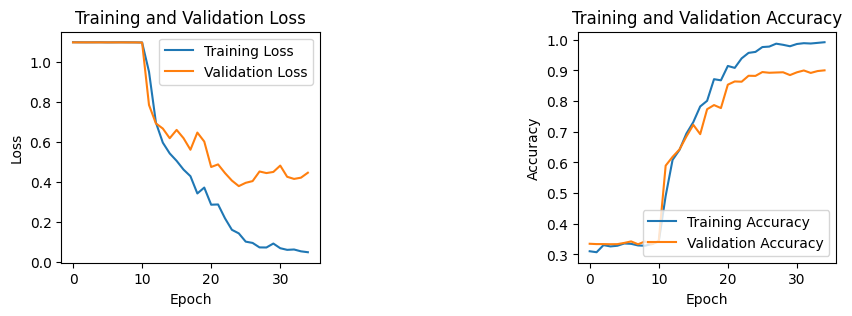

297/297 [==============================] - 2s 6ms/step - loss: 0.3789 - accuracy: 0.8823
Final Validation Loss: 0.3788781464099884
Final Validation Accuracy: 0.8823158144950867


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

def create_model(max_words, embedding_dim, maxlen):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen),
        tf.keras.layers.LSTM(units=128, return_sequences=True),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.LSTM(units=64),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=3, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model training
def train_model(model, x_train, y_train, x_validation, y_validation, epochs=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=(x_validation, y_validation),
        callbacks=[early_stopping]
    )
    return history

# Plotting metrics
def plot_metrics(history):
    plt.figure(figsize=(10, 3))
    plt.subplots_adjust(wspace=1)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Load the data
data = np.load('/content/drive/MyDrive/sentiment_analysis/yelp_review_data_preprocessed.npz', allow_pickle=True)
x_train = data['x_train']
y_train = data['y_train']
x_validation = data['x_validation']
y_validation = data['y_validation']

# Convert labels into one-hot format
num_classes = 3
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_validation_one_hot = to_categorical(y_validation, num_classes=num_classes)

model = create_model(max_words = 1000, embedding_dim = 128, maxlen = 104)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train_one_hot,
    epochs=100,
    batch_size=16,
    validation_data=(x_validation, y_validation_one_hot),
    callbacks=[early_stopping]
)

plot_metrics(history)

# Save model
model.save("/content/drive/MyDrive/sentiment_analysis/sentiment_analysis_model.keras")

# Display metrics for evaluation
final_loss, final_accuracy = model.evaluate(x_validation, y_validation_one_hot)
print(f"Final Validation Loss: {final_loss}")
print(f"Final Validation Accuracy: {final_accuracy}")

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import pickle

def display_predictions_with_text_no_encoder(model, x_test, y_test, num_samples_to_display, tokenizer):
    random_indices = np.random.choice(x_test.shape[0], num_samples_to_display, replace=False)
    x_samples = x_test[random_indices]
    y_samples = y_test[random_indices]

    predictions = model.predict(x_samples) # Make predictions
    predicted_labels = np.argmax(predictions, axis=1) # Get the index of the class with the highest predicted probability

    # Map the labels to their respective sentiment categories
    sentiment_map = {0: 'Positive', 1: 'Negative', 2: 'Neutral'}
    predicted_labels = [sentiment_map[label] for label in predicted_labels]

    decoded_texts = [tokenizer.sequences_to_texts([seq])[0] for seq in x_samples] # Decode the tokenized sequences back into text

    # Display the review, predicted label, and actual label for each test case
    print(f"{num_samples_to_display} Random Entries from Test Dataset with Predictions and Text Sequences:")
    print("--------------------")
    for i in range(num_samples_to_display):
        print(f"Data Row {i + 1}:")
        print("Real Label:", sentiment_map[y_samples[i]])
        print("Predicted Label:", predicted_labels[i])
        print("Actual Text Sequence:", decoded_texts[i])
        print("--------------------")

# Load data
data = np.load('/content/drive/MyDrive/sentiment_analysis/yelp_review_data_preprocessed.npz', allow_pickle=True)
x_test = data['x_test']
y_test = data['y_test']

# Load model
model_path = '/content/drive/MyDrive/sentiment_analysis/sentiment_analysis_model.keras'
model = load_model(model_path)

# Load tokenizer
with open('/content/drive/MyDrive/sentiment_analysis/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

display_predictions_with_text_no_encoder(model, x_test, y_test, num_samples_to_display=5, tokenizer=tokenizer)

1/1 [==============================] - 1s 619ms/step
5 Random Entries from Test Dataset with Predictions and Text Sequences:
--------------------
Data Row 1:
Real Label: Neutral
Predicted Label: Neutral
Actual Text Sequence: food is decent beer is solid service is glacial i would ha e definitely tried a sampler if it didn't take forever for service got a growler to go by the time the check came i could have made it a growler to drink there
--------------------
Data Row 2:
Real Label: Negative
Predicted Label: Negative
Actual Text Sequence: yuck this place was horrible bland cafeteria style food thats luke warm with no flavor i received kraft mac n cheese from a box lmao wow green beans from a can didn't even doctor them up just directly from the can never again even the hot chocolate was gross n made with water
--------------------
Data Row 3:
Real Label: Neutral
Predicted Label: Negative
Actual Text Sequence: pizza wasn't too bad but the bartender didn't have much knowledge of the bee